# Syntactic Parsing for ABSA

Parse tweets to CoNLL-U format for aspect-based sentiment analysis.

## Setup

In [11]:
!pip install -q spacy pandas tqdm matplotlib seaborn
!python -m spacy download en_core_web_sm

/usr/bin/python: No module named spacy


In [12]:
import pandas as pd
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [13]:
df = pd.read_csv("data/COVIDSenti/COVIDSenti.csv")
print(f"Loaded {len(df):,} tweets")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
df.head(3)

Loaded 90,000 tweets

Label distribution:
label
neu    67385
neg    16335
pos     6280
Name: count, dtype: int64


,tweet,label
0,Coronavirus | Human Coronavirus Types | CDC ht...,neu
1,"@shehryar_taseer That‚Äôs üíØ true , \nCorona...",neu
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg


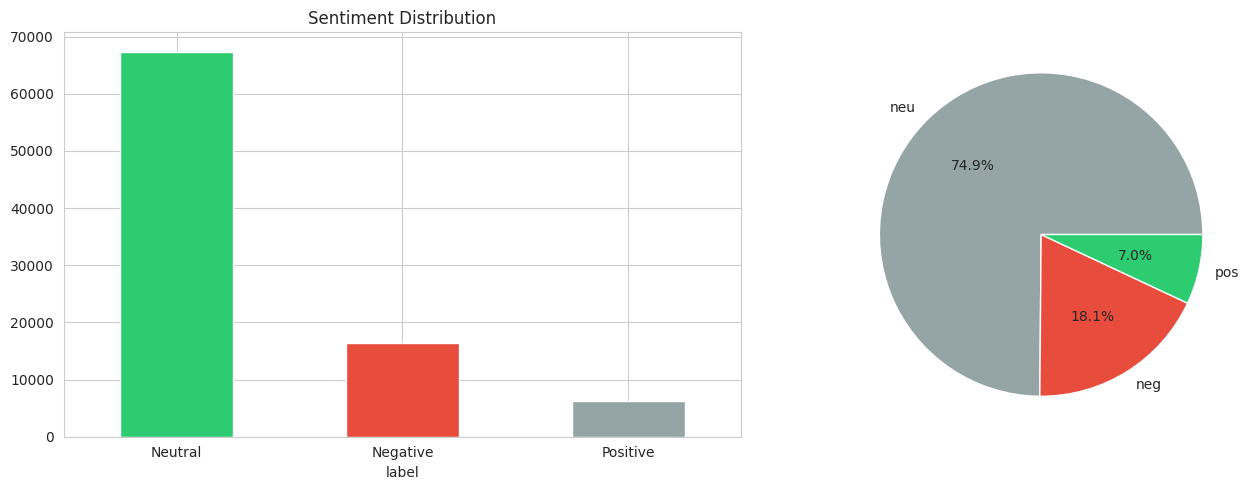

In [14]:
# Visualize distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
df['label'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax[0].set_title('Sentiment Distribution')
ax[0].set_xticklabels(['Neutral', 'Negative', 'Positive'], rotation=0)

df['label'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                colors=['#95a5a6', '#e74c3c', '#2ecc71'])
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

## Parsing Functions

In [15]:
def token_to_conllu(token, idx):
    """Convert spaCy token to CoNLL-U format."""
    head_idx = token.head.i - token.sent[0].i + 1 if token.head.i != token.i else 0
    
    return "\t".join([
        str(idx),
        token.text,
        token.lemma_,
        token.pos_,
        token.tag_,
        "_",
        str(head_idx),
        token.dep_,
        "_",
        "_"
    ])


def parse_to_conllu(text, nlp):
    """Parse text to CoNLL-U format."""
    try:
        doc = nlp(text)
        lines = []
        for sent in doc.sents:
            lines.append(f"# text = {sent.text}")
            for idx, token in enumerate(sent, start=1):
                lines.append(token_to_conllu(token, idx))
            lines.append("")
        return "\n".join(lines).strip()
    except Exception as e:
        print(f"Error: {text[:50]}... - {e}")
        return ""

## Example Parse

In [16]:
nlp = spacy.load("en_core_web_sm")

example = "The vaccine rollout has been slow but the side effects are minimal."
print(f"Tweet: {example}\n")
print(parse_to_conllu(example, nlp))

Tweet: The vaccine rollout has been slow but the side effects are minimal.

# text = The vaccine rollout has been slow but the side effects are minimal.
1	The	the	DET	DT	_	2	det	_	_
2	vaccine	vaccine	NOUN	NN	_	3	compound	_	_
3	rollout	rollout	NOUN	NN	_	5	nsubj	_	_
4	has	have	AUX	VBZ	_	5	aux	_	_
5	been	be	AUX	VBN	_	0	ROOT	_	_
6	slow	slow	ADJ	JJ	_	5	acomp	_	_
7	but	but	CCONJ	CC	_	5	cc	_	_
8	the	the	DET	DT	_	10	det	_	_
9	side	side	NOUN	NN	_	10	compound	_	_
10	effects	effect	NOUN	NNS	_	11	nsubj	_	_
11	are	be	AUX	VBP	_	5	conj	_	_
12	minimal	minimal	ADJ	JJ	_	11	acomp	_	_
13	.	.	PUNCT	.	_	11	punct	_	_


In [17]:
# Visualize dependency tree
from spacy import displacy
displacy.render(nlp(example), style="dep", jupyter=True, options={'distance': 100})

## Parse Sample

In [18]:
# Test on 10 tweets
df_sample = df.sample(n=10, random_state=42).reset_index(drop=True)
df_sample['conllu_parse'] = ""

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    df_sample.at[idx, 'conllu_parse'] = parse_to_conllu(str(row['tweet']), nlp)

print("\nSample results:")
for i in range(3):
    print(f"\n{i+1}. {df_sample.iloc[i]['tweet'][:80]}...")
    print(f"   Label: {df_sample.iloc[i]['label']}")
    print(f"   Parse (first 200 chars): {df_sample.iloc[i]['conllu_parse'][:200]}...")

100%|██████████| 10/10 [00:00<00:00, 105.57it/s]


Sample results:

1. @aibohponis CHINA SUCKS . Coronavirus is your fault I think they made it to dest...
   Label: neg
   Parse (first 200 chars): # text = @aibohponis CHINA SUCKS .
1	@aibohponis	@aibohponis	PROPN	NNP	_	2	compound	_	_
2	CHINA	CHINA	PROPN	NNP	_	3	nsubj	_	_
3	SUCKS	suck	VERB	VBZ	_	0	ROOT	_	_
4	.	.	PUNCT	.	_	3	punct	_	_

# text = C...

2. Biotech exec: Coronavirus vaccine will take months https://t.co/PH3B4KagwX...
   Label: neu
   Parse (first 200 chars): # text = Biotech exec: Coronavirus vaccine will take months https://t.co/PH3B4KagwX
1	Biotech	Biotech	PROPN	NNP	_	2	compound	_	_
2	exec	exec	NOUN	NN	_	0	ROOT	_	_
3	:	:	PUNCT	:	_	2	punct	_	_
4	Coronavi...

3. Coronavirus Impact on Search Marketing via martinibuster https://t.co/9M4WAo2ziy...
   Label: neu
   Parse (first 200 chars): # text = Coronavirus Impact on Search Marketing via martinibuster https://t.co/9M4WAo2ziy
1	Coronavirus	Coronavirus	PROPN	NNP	_	2	compound	_	_
2	Impact	Impact	PROPN	NNP	_	0	ROOT	_	_
3	on	on	A

## Process Full Dataset

Use the preprocessing script for the full dataset (takes ~10-15 min):
```bash
cd data/COVIDSenti
python preprocess_syntactic.py --input COVIDSenti.csv --output COVIDSenti_full_parsed.csv
```

## Load Parsed Data

In [19]:
try:
    df_parsed = pd.read_csv("data/COVIDSenti/COVIDSenti_full_parsed.csv")
    print(f"Loaded {len(df_parsed):,} parsed tweets")
    print(f"Columns: {df_parsed.columns.tolist()}")
    
    # Stats
    df_parsed['parse_length'] = df_parsed['conllu_parse'].str.len()
    df_parsed['num_tokens'] = df_parsed['conllu_parse'].str.count('\n') / 2
    
    print(f"\nAverage parse length: {df_parsed['parse_length'].mean():.0f} chars")
    print(f"Average tokens: {df_parsed['num_tokens'].mean():.1f}")
    
except FileNotFoundError:
    print("Pre-processed file not found. Run preprocessing script first.")

Loaded 90,000 parsed tweets
Columns: ['tweet', 'label', 'conllu_parse']

Average parse length: 794 chars
Average tokens: 9.8


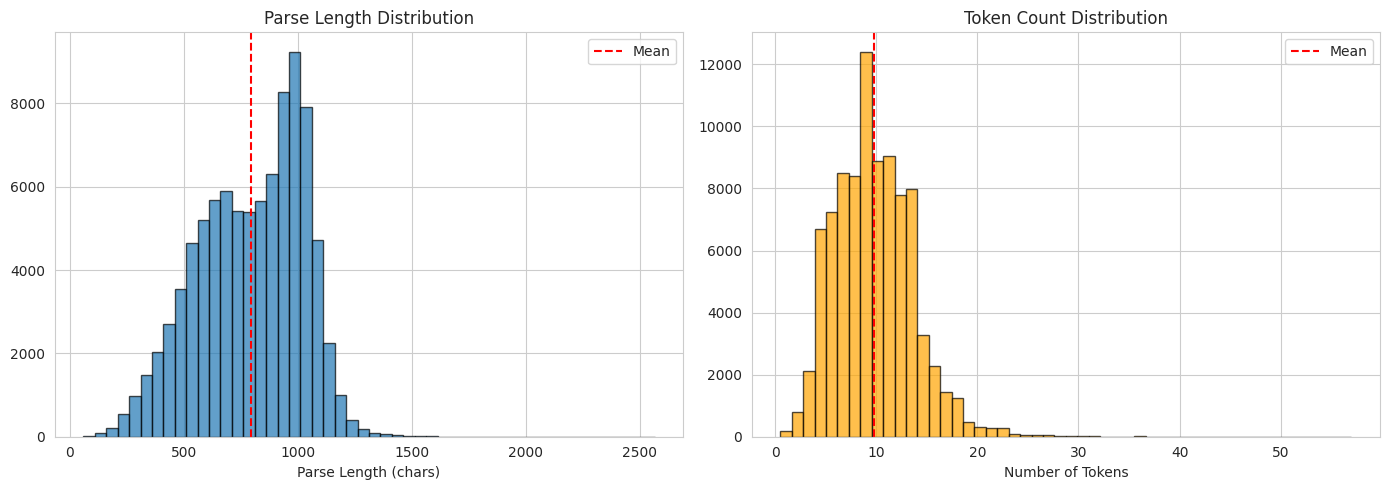

In [20]:
# Visualize parse statistics
if 'df_parsed' in locals():
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    ax[0].hist(df_parsed['parse_length'], bins=50, edgecolor='black', alpha=0.7)
    ax[0].axvline(df_parsed['parse_length'].mean(), color='red', linestyle='--', label='Mean')
    ax[0].set_xlabel('Parse Length (chars)')
    ax[0].set_title('Parse Length Distribution')
    ax[0].legend()
    
    ax[1].hist(df_parsed['num_tokens'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    ax[1].axvline(df_parsed['num_tokens'].mean(), color='red', linestyle='--', label='Mean')
    ax[1].set_xlabel('Number of Tokens')
    ax[1].set_title('Token Count Distribution')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

## Next: Teacher Annotation

Use Qwen2.5-72B to generate reasoning traces for:
1. Syntactic analysis
2. Aspect extraction
3. Opinion extraction  
4. Sentiment classification
5. Emotion classification

See `annotation/prompts.py` for prompt templates.